# Running Inference
This code runs the test for the POD case. The testing data, in this case initial conditions and PDE parameters, should have respectively dimensions [B,1,C,x1_dim,x2_dim, ...] and [B,N_m], where B is the batch size, C is the number channels of the solution fields, x1_dim,x2_dim and so on are the spatial resolutions of first and second dimensions and so on, and N_m is the number of parameters

# Import necessary functions

In [1]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import pandas as pd
import re
import sys
import yaml
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import time
import h5py
tc.set_default_dtype(tc.float32)


# Functions

In [2]:
def load_config(config_path: str):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Set path to saved reduced basis, path to data for testing and necessary directories

In [3]:
path_models = '../../datasets/gaussian_shape/Models/POD/1_mode'
data_generation_test = '../../../../../../scratch/aalelonghi/gaussian_shapes/'
directory_images = path_models+'/Images/'
os.makedirs(directory_images, exist_ok=True)
sys.path.append(path_models + '/scripts')
from models.POD.POD_model import *

#set device
device = tc.device("cuda:1") if tc.cuda.is_available() else tc.device("cpu")
print(f'Selected device: {device}')

#read file with normalization of inputs
normalization = pd.read_csv(path_models+'/Normalization.csv')
string_field = normalization['Field'][0].split("), 'Min': tensor(")
ma_field = [float(x) for x in string_field[0][16:-2].split(",")]
mi_field = [float(x) for x in string_field[1][1:-3].split(",")]

print('maximum value field', ma_field)
print('minimum value field', mi_field)

global_information = load_config(path_models + '/scripts/configs/global_information.yaml')
model_information = load_config(path_models + '/scripts/configs/information_POD.yaml')
global_information['PATH'] = 'boh'
print(global_information)

Selected device: cuda:1
maximum value field [1.0]
minimum value field [0.0]
{'physics_model': 'datasets/gaussian_shape', 'description': 'POD/1_mode', 'epochs': 5000, 'learning_rate': 0.0014, 'dim_input': [1, 2], 'side_size': 128, 'gamma_lr': 0.99, 'batch_size': 1, 'warmup_lr': 10, 'clipping': [0, 2.5], 'model': 'POD', 'class_name': 'POD', 'device': 'cuda:1', 'num_workers': 8, 'data_path': '../../../../../scratch/aalelonghi/gaussian_shapes/', 'training_data_path': 'training_field_1.npy', 'validation_data_path': 'validation_field.npy', 'checkpoint': False, 'normalization_field_ma': [True, 1.0], 'normalization_field_mi': [True, 0.0], 'PATH': 'boh'}


# Load matrices U, S, V got from POD

In [4]:
loaded_matrices = tc.load(path_models +'/SVD/svd.pth')
U, S, V = loaded_matrices['U'].detach().cpu().numpy() , loaded_matrices['S'].detach().cpu().numpy() , loaded_matrices['V'].detach().cpu().numpy() 
print('U', np.shape(U))
print('S', np.shape(S))
print('V', np.shape(V))

/tmp/ipykernel_3492331/3766777064.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_matrices = tc.load(path_models +'/SVD/svd.pth')


U (1, 1)
S (1,)
V (1, 16384)


# Define testing objects

In [5]:
testing_time_serie = np.array(np.load(data_generation_test+"/test_field.npy"),dtype="float32") #should be of size [B,T,C,W,H]
testing_parameters = np.array(np.load(data_generation_test+"/test_field_parameters.npy"),dtype="float32")
#testing_T = np.array(np.load(data_generation_test+"/testing_T.npy"),dtype="float32")
#ic = np.array(np.load(data_generation_test+"/testing_initial_conditions.npy"),dtype="float32")
testing_T = np.array([0.0])#np.arange(0,1.05,0.05,dtype="float32")

#testing_time_serie_diff_time = np.load('../../../../../../../scratch/aalelonghi/benchmark/burgers_0.001/discretization_0.01/testing_output.npy')
#inference_T = np.float32(np.arange(0,2.01,0.01))

#if needed, adjust the dimension of testing_time_serie
#testing_time_serie = testing_time_serie[:,:,None,:]
#testing_time_serie_diff_time = testing_time_serie_diff_time[:,:,None,:]

print('testing_time_serie',np.shape(testing_time_serie ))
#print('testing_parameters',np.shape(testing_parameters ))
#print('ic',np.shape(ic ))
#print('testing_T',np.shape(testing_T ))
#print('testing_time_serie_diff_time',np.shape(testing_time_serie_diff_time ))
#print('inference_T',np.shape(inference_T ))

testing_time_serie (1000, 1, 1, 128, 128)


# Define some needed details

In [6]:
latent_dim = model_information['latent_dimension'] #dimension of the latent space 
dim_field = global_information['dim_input'] # first dimension is the channels of the solution field, second is the number of spatial dimensions

# Reduce data

In [7]:
def normalize_field_known_values(F, ma, mi):
    F_new = F.copy()
    for count in range(len(ma)):
        F_new[:,:,count,...] = (F_new[:,:,count,...]-mi[count])/(ma[count]-mi[count])
    return F_new

def inverse_normalization_field(F,ma,mi, spatial_dimensions): #here one less dimension because the dimension 1 is squeezed in that part of the code
    F_new = F.copy()
    if spatial_dimensions == 1:
        for count in range(len(ma)):
            F_new[...,count,:] = F_new[...,count,:]*(ma[count]-mi[count]) + mi[count]
        return F_new
    elif spatial_dimensions == 2:
        for count in range(len(ma)):
            F_new[...,count,:,:] = F_new[...,count,:,:]*(ma[count]-mi[count]) + mi[count]
        return F_new

In [8]:
size = np.shape(testing_time_serie)
print('testing_time_serie', np.shape(testing_time_serie))
testing_data = normalize_field_known_values(testing_time_serie, ma_field, mi_field)
testing_data = np.reshape(testing_data,(size[0]*size[1],-1))
print('testing_data', np.shape(testing_data))
POD_coefficients = V @ testing_data.T
print('POD_coefficients', np.shape(POD_coefficients))
reconstructed_fields = POD_coefficients.T @ V
print('reconstructed_fields', np.shape(reconstructed_fields))
reconstructed_fields = inverse_normalization_field(np.reshape(reconstructed_fields, (size)),ma_field,mi_field,dim_field[1] )
print('reconstructed_fields', np.shape(reconstructed_fields))
POD_coefficients = POD_coefficients.T
print('POD_coefficients', np.shape(POD_coefficients))

testing_time_serie (1000, 1, 1, 128, 128)
testing_data (1000, 16384)
POD_coefficients (1, 1000)
reconstructed_fields (1000, 16384)
reconstructed_fields (1000, 1, 1, 128, 128)
POD_coefficients (1000, 1)


reconstructed_fields (1000, 1, 1, 128, 128)
testing_time_serie (1000, 1, 1, 128, 128)
average nRMSE =  0.9998128


Text(0.5, 1.0, 'Relative error of AutoEncoding across testing dataset')

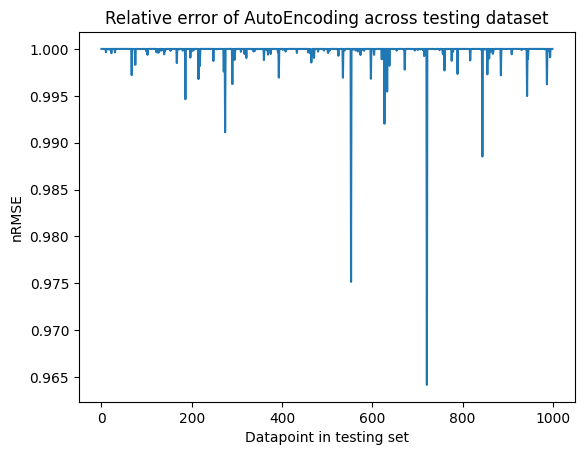

In [9]:
size1 = np.shape(reconstructed_fields)
size2 = np.shape(testing_time_serie)
print('reconstructed_fields',size1)
print('testing_time_serie',size2)
error = []
for count, i in enumerate(reconstructed_fields):
    for j in np.arange(0,size1[1],1):
        err = np.linalg.norm(i[j].flatten()-testing_time_serie[count][j].flatten())/np.linalg.norm(testing_time_serie[count][j].flatten())
        error.append(err)
err = np.mean(error)
print('average nRMSE = ', err)
plt.plot(error)
plt.xlabel('Datapoint in testing set')
plt.ylabel('nRMSE') 
plt.title('Relative error of AutoEncoding across testing dataset')

[ 0.4440292  -0.10058594  0.11804724]


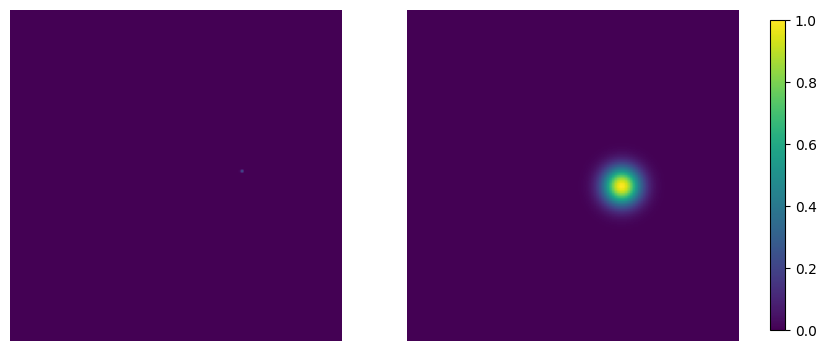

In [10]:
sample = 10
print(testing_parameters[sample])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Get the global min and max across both images
vmin = min(reconstructed_fields[sample][0][0].min(), testing_time_serie[sample][0][0].min())
vmax = max(reconstructed_fields[sample][0][0].max(), testing_time_serie[sample][0][0].max())

# Show first image
img1 = axes[0].imshow(reconstructed_fields[sample][0][0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].axis("off")  # Hide axes

# Show second image
img2 = axes[1].imshow(testing_time_serie[sample][0][0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].axis("off")  # Hide axes

# Create a truly common colorbar
cbar = fig.colorbar(img1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

Text(0.5, 1.0, 'Modes importance')

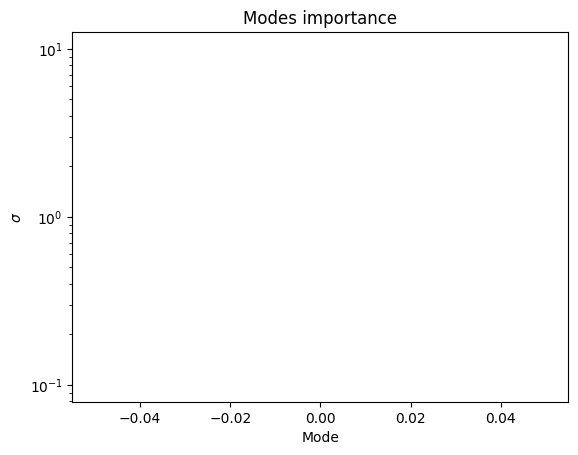

In [11]:
plt.plot(S/np.sum(S))
plt.yscale('log')
plt.xlabel('Mode')
plt.ylabel(r'$\sigma$')
plt.title('Modes importance')

/tmp/ipykernel_1055575/715019771.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 20)


Parameters first sample:  [0.56711966 0.9033596  0.0817458 ]
Parameters second sample:  [0.37543297 0.25779936 0.18526518]


/tmp/ipykernel_1055575/715019771.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(fontsize = 16)


<Figure size 2000x1000 with 0 Axes>

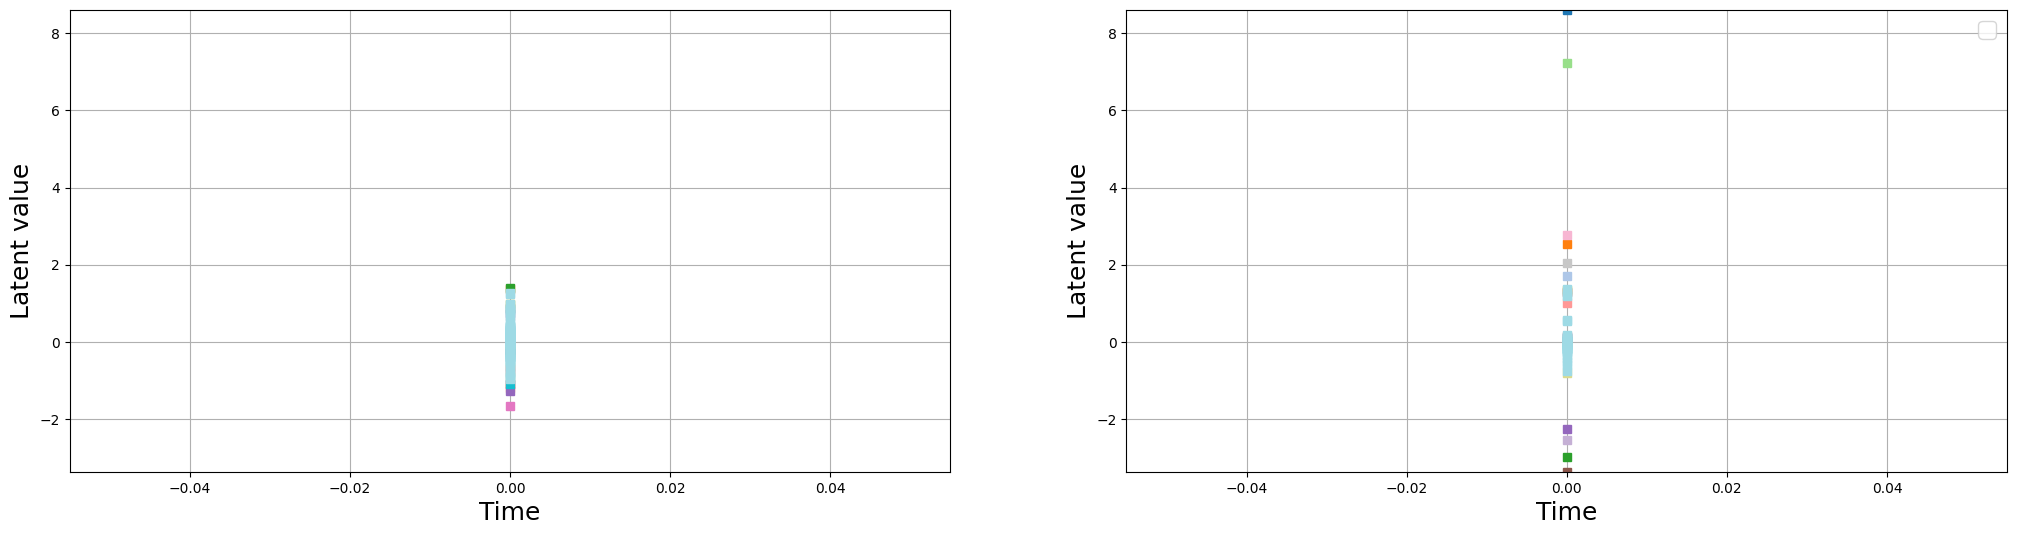

In [19]:
# # LOOK AT LATENT SPACE (FROM ENCODING TRUE SOLUTION ONLY)
plt.figure(figsize=(20,10))
colors = plt.cm.get_cmap('tab20', 20) 
samples = [1, 80]
print('Parameters first sample: ', testing_parameters[samples[0]])
print('Parameters second sample: ', testing_parameters[samples[1]])
fig, ax = plt.subplots(1, 2, figsize = (25,6))
for count, i  in enumerate(np.arange(0,200,1)):  
    ax[0].plot(testing_T[0:],POD_coefficients[samples[0]][i],marker='s',color = colors(count))
    ax[1].plot(testing_T[0:],POD_coefficients[samples[1]][i],marker='s',color = colors(count))
ma = np.max([np.max(POD_coefficients[samples[0]]),np.max(POD_coefficients[samples[1]])])
mi = np.min([np.min(POD_coefficients[samples[0]]),np.min(POD_coefficients[samples[1]])])
ax[0].set_ylim(mi,ma)
ax[1].set_ylim(mi,ma)

ax[0].grid()
ax[1].grid()
#plt.yscale('log')
ax[0].set_xlabel('Time', fontsize = 18)
ax[1].set_xlabel('Time', fontsize = 18)
ax[0].set_ylabel('Latent value', fontsize = 18)
ax[1].set_ylabel('Latent value', fontsize = 18)
legend = plt.legend(fontsize = 16)
#plt.savefig(directory_images+'/latent_varyingt_time_comparison_tot.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

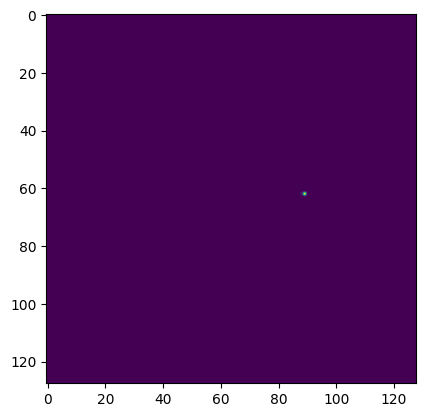

In [12]:
plt.imshow(np.reshape(V,(128,128)))